Using TensorFlow backend.


-----開始讀取數據-----
train_data.shape: (12508, 256, 256, 3)
train_labels.shape: (12508, 256, 256, 1)
-----開始訓練模型----
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
______________

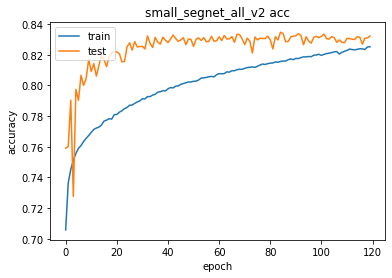

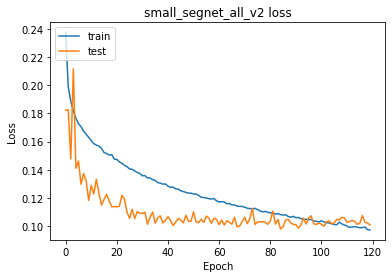

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 16)      64    

In [1]:
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, UpSampling2D, ZeroPadding2D,Input,BatchNormalization, Dropout,Add,Dense
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD, Adam 
from keras.utils import np_utils 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.callbacks 
import time
tf.config.list_physical_devices('GPU')

print("-----開始讀取數據-----")

file = np.load('building_data_new.npz')
train_data = file['train_data']
train_labels = file['train_labels']

#檢查是否有匯入
print ("train_data.shape:",train_data.shape)
print ("train_labels.shape:",train_labels.shape)


train_data = train_data.astype('float32')
train_labels = train_labels.astype('float32')

#正規化到[0,1]之間

train_data = train_data/255
train_labels = train_labels/255

import gc
def train_model():
    
    global history
    
    initializer = tf.keras.initializers.he_normal(seed = None)
    
    input_img= Input(shape=(256, 256, 3))
    # Encoder 使用卷積層，激活函數用 relu，輸入的維度就是上面定義的 input_img
    #大小 = 256*256
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    #大小 = 128*128
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    #大小 = 64*64
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    
    #大小 = 32*32
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)  #大小 = 16*16 為編碼器設置了一個名稱，以便能夠訪問它

    # Decoder 的過程與 Encoder 正好相反，需要跟 Encoder 的神經網絡層做相對應，相對應的激活函數也是一樣，但這邊在解碼中最後一層使用的激活函數是 sigmoid
    x = UpSampling2D((2, 2))(encoded)
    #大小32*32
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)    
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
       
    x = UpSampling2D((2, 2))(x)
    #大小64*64
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)    
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    #大小128*128
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)    
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    #大小256*256
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    

        
    # 用 Model 來搭建模型，輸入為圖片，輸出是解碼的結果
    autoencoder = Model(input_img, decoded)  
    
    print(autoencoder.summary())
    
    # 編譯模型，optimizer 使用 nadam，loss 使用 categorical_crossentropy 
    autoencoder.compile(optimizer='nadam', loss=tf.keras.losses.MeanAbsoluteError(),metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    # early stop 這版本先不要設early stop
    #early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30 , mode = 'min' , min_delta = 0.001,restore_best_weights=True)

    #validation_data=(test_data, test_labels) 暫時捨棄 使用split
    history = autoencoder.fit(
                    train_data,train_labels, 
                    epochs=120,
                    batch_size=30,
                    validation_split = 0.1,
                    shuffle = True,
                    )
                    
    autoencoder.save('small_batch_segnet_all_v2.h5')
    #ec = autoencoder.get_layer('encoder').output
    #儲存完後刪掉model 釋放記憶體
    del autoencoder
    gc.collect()

print('-----開始訓練模型----')
t0 = time.time()
train_model() 

print('-----訓練完成-------')
t1 = time.time()
print('訓練時間:'+ str(round((t1-t0)/60,2))+ ' min')

#將訓練過程損失可視化
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('small_segnet_all_v2 acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('small_segnet_all_v2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

  
del history
gc.collect()

#check 有沒有存到
autoencoder2 = load_model('small_batch_segnet_all_v2.h5')
print(autoencoder2.summary())


In [ ]:
# 這版本是 v1 但是不家early stopping
# 想法是先train 150 次 看有沒有收斂好一點